In [1]:
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
import datetime

import numpy as np
import os
from pandas.plotting import table
import re



In [2]:
def make_window_sum(series, window_in_day):
    item_sum = []
    for i, _ in enumerate(series):
        item_tmp = 0
        #if i > window:
        for j in range(window):
            if i-j >= 0:
                item_tmp += series[i-j]
            #print item_tmp
        item_sum.append(item_tmp)

    return pd.Series(data=item_sum, index=series.index)

# time window in days for plots of working sets
windows = [7,30,90]

prefix = "/eos/user/d/dciangot/www/"

In [248]:
# AVAILABLE DATASETS:
# ws_all_18.pkl.gz
# ws_T2_US_18.pkl.gz
# ws_T2_IT_18.pkl.gz
# ws_T2_ES_18.pkl.gz
# ws_T2_DE_18.pkl.gz
# ws_T2_FR_18.pkl.gz
#
# Until 2019-04:
# ws_all_19.pkl.gz
# ws_T2_US_19.pkl.gz
# ws_T2_IT_19.pkl.gz
# ws_T2_ES_19.pkl.gz
# ws_T2_DE_19.pkl.gz
# ws_T2_FR_19.pkl.gz

name = 'all_19'

with open('mkdir.sh', 'w') as ostream:
    ostream.write("""#!/bin/bash
mkdir -p %s/%s""" % (prefix, name))

!source ./mkdir.sh
# Period of time
## 2018
#start_date = datetime.datetime(2017,12,31)
#end_date = datetime.datetime(2018,12,31)
#total_hrs = (datetime.datetime(2018,12,31) - datetime.datetime(2017,12,31)).days*24
## 2019
start_date = datetime.datetime(2018,12,31)
end_date = datetime.datetime(2019,4,30)
total_hrs = (end_date - start_date).days*24

data = pd.read_pickle('pandas_dfs/ws_mcFalse_%s.pkl' % name)

data_mc = pd.read_pickle('pandas_dfs/ws_mcTrue_%s.pkl' % name)

data.set_index('day', inplace=True)
data = data.sort_index()
data = data.dropna(subset=['CMSSite'])

data_mc.set_index('day', inplace=True)
data_mc = data_mc.sort_index()

print data_mc.WallClock.sum()


30728385.915000003


In [249]:
data_mc.size

4893834

In [250]:
data['CPUTime'] = data['CPUTime']/data['RequestCpus']

ignore_overflow = (data[(data['InputData']=='Offsite') & (data['OverflowType']!='IgnoreLocality')].WallClock.sum() == 0.0)


print "Ignore overflow:", ignore_overflow
print data.columns
print data_mc.columns
print data.Type.size

Ignore overflow: False
Index([          u'CRAB_DataBlock',                  u'Country',
                    u'RequestCpus',                     u'Type',
                        u'CMSSite',            u'CRAB_Workflow',
                    u'CRAB_UserHN',           u'OVERFLOW_CHECK',
                      u'InputData',           u'd_data_tier_id',
                     u'block_size',             u'OverflowType',
       u'Chirp_CRAB3_Job_ExitCode',                u'WallClock',
                        u'CPUTime',                 u'CoreTime',
                     u'data_label',                 u'ExitCode'],
      dtype='object')
Index([                 u'Country',              u'RequestCpus',
                        u'CMSSite',            u'CRAB_Workflow',
                    u'CRAB_UserHN', u'Chirp_CRAB3_Job_ExitCode',
                         u'CpuEff',                u'WallClock',
                        u'CPUTime',                 u'CoreTime',
                       u'ExitCode'],
      d

In [252]:
print data_mc.WallClock.sum()/total_hrs

10669.578442708334


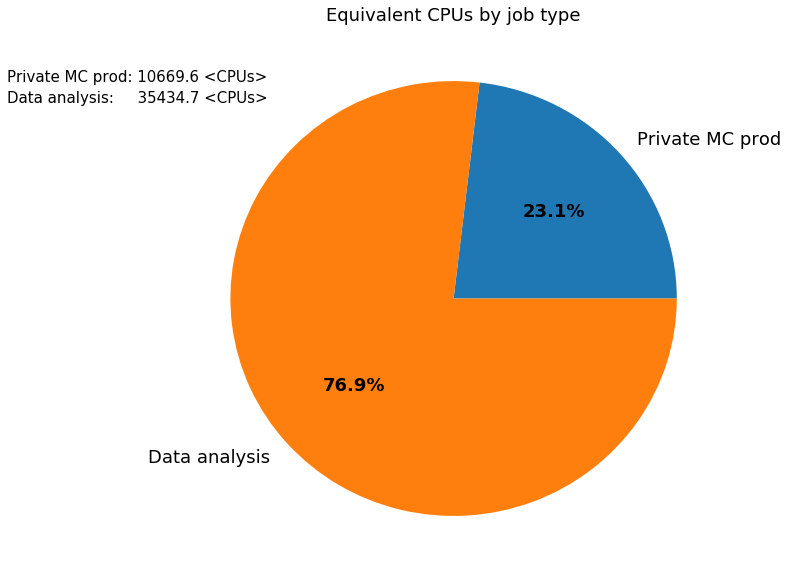

In [253]:

mc_cpus = data_mc.WallClock.sum()/total_hrs
data_cpus = (data[(data['ExitCode']>=0.0)].WallClock.sum())/total_hrs

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.text(-2, 1,   "Private MC prod: %1.1f <CPUs>" % mc_cpus, fontsize=15)
ax.text(-2, 0.9, "Data analysis:     %1.1f <CPUs>" % data_cpus, fontsize=15)
wedges, texts, autotexts = ax.pie([mc_cpus, data_cpus], labels=["Private MC prod", "Data analysis"], autopct='%1.1f%%', textprops={"fontsize":18})

plt.setp(texts, size=18)
plt.setp(autotexts, size=18, weight="bold")
ax.set_title('Equivalent CPUs by job type',fontdict={"fontsize":18})

plt.savefig('plots/%s/cpu_by_job_type.png' % name)
plt.show()


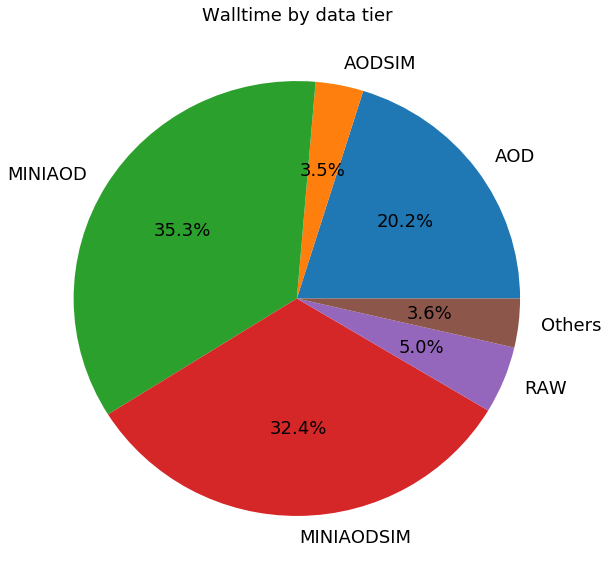

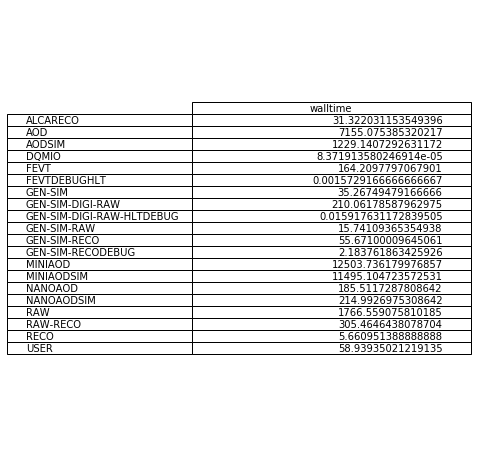

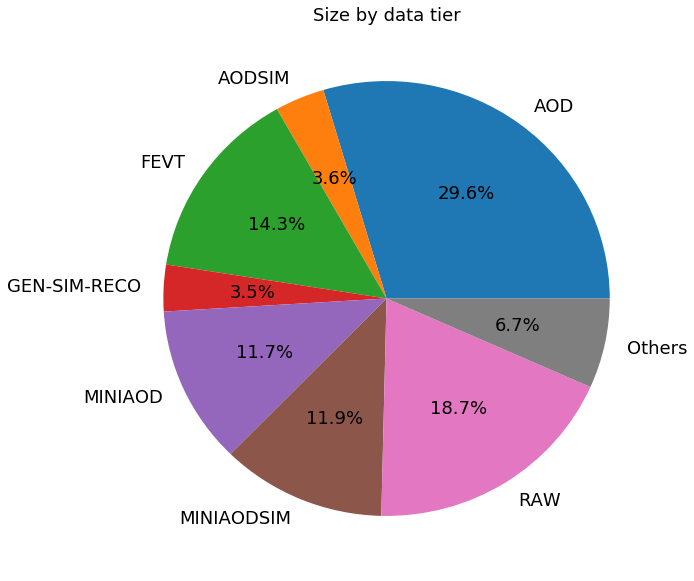

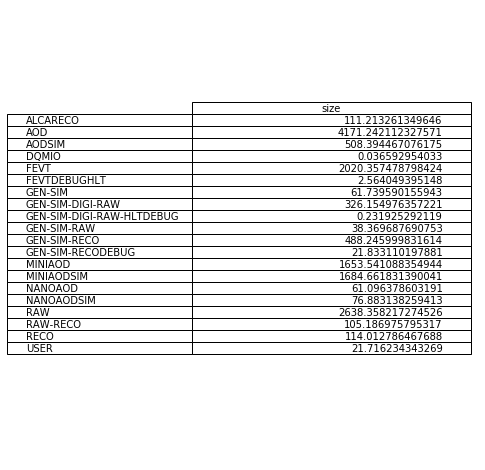

In [254]:
data = data.dropna(subset=['InputData'])

wc_series = data.groupby('data_label').apply(lambda x: x['WallClock'].sum())

wc_tier = pd.DataFrame({'walltime': wc_series.values}, index=wc_series.index)

sum_wc = data.WallClock.sum()

wc_tier_all = wc_tier.walltime

wall_other = wc_tier[wc_tier['walltime']/sum_wc <= 0.03].walltime.sum()
wall_show = wc_tier[wc_tier['walltime']/sum_wc > 0.03].walltime

wc_tier = pd.DataFrame({'walltime': np.append(wall_show.values,[wall_other])},
                       index=np.append(wall_show.index, ["Others"]))

ax = wc_tier.plot.pie(y='walltime', title='WallClock time by data tier', autopct='%1.1f%%', figsize=(10, 10), fontsize=18, legend=False)

ax.set_title('Walltime by data tier', fontdict={"fontsize":18})
ax.set_ylabel("", fontdict={"fontsize":18})

plt.savefig('%s/%s/wallClock_time_by_data_tier.png' % (prefix, name))
plt.show()


plt.figure(figsize=(5, 8))
ax2 = plt.subplot(111)
plt.axis('off')
tbl = table(ax2, wc_tier_all/total_hrs, loc='center')
tbl.auto_set_font_size(True)

#tbl.set_fontsize(10)

plt.savefig('%s/%s/walltime_by_data_tier_table.png' % (prefix, name))


wc_series = data.drop_duplicates(subset=['block_size']).groupby('data_label').apply(lambda x: x['block_size'].sum())
wc_tier = pd.DataFrame({'size': wc_series.values}, index=wc_series.index)

sum_size = wc_tier["size"].sum()

wc_tier_all = wc_tier["size"]

wall_other = wc_tier[wc_tier['size']/sum_size <= 0.03]["size"].sum()
wall_show = wc_tier[wc_tier['size']/sum_size > 0.03]["size"]

wc_tier = pd.DataFrame({'size': np.append(wall_show.values,[wall_other])},
                       index=np.append(wall_show.index, ["Others"]))
#print wc_tier/1E12

ax = wc_tier.plot.pie(y='size', autopct='%1.1f%%', figsize=(10, 10), fontsize=18, legend=False)

ax.set_title('Size by data tier', fontdict={"fontsize":18})
ax.set_ylabel("", fontdict={"fontsize":18})

plt.savefig('%s/%s/size_by_data_tier.png' % (prefix, name))
plt.show()

plt.figure(figsize=(5, 8))
ax2 = plt.subplot(111)
plt.axis('off')
tbl = table(ax2, wc_tier_all/1e12, loc='center')
tbl.auto_set_font_size(True)

#tbl.set_fontsize(10)

plt.savefig('%s/%s/size_by_data_tier_table.png' % (prefix, name))

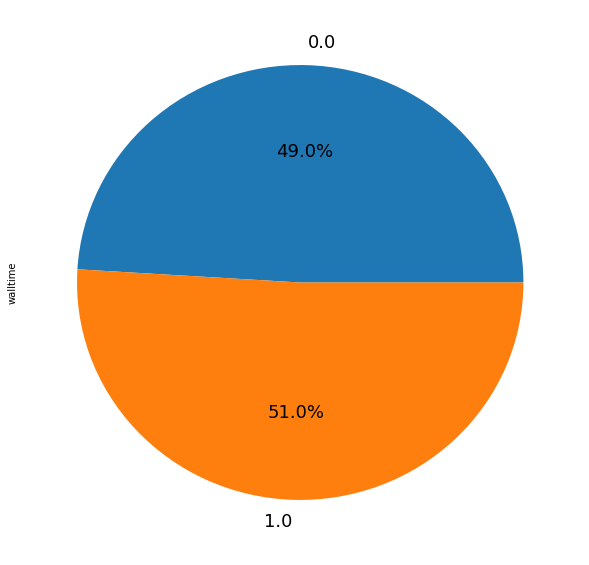

In [255]:
plot_series = data[data['InputData']=='Offsite'].groupby('OVERFLOW_CHECK').apply(lambda x: x['WallClock'].sum())
wc_remote_by_overflow = pd.DataFrame({'walltime': plot_series.values}, index=plot_series.index)

wc_remote_by_overflow.plot.pie(y='walltime', autopct='%1.1f%%', figsize=(10, 10), fontsize=18, legend=False)

ax.set_title('Remote read wallClock time by overflow', fontdict={"fontsize":18})
ax.set_ylabel("", fontdict={"fontsize":18})

plt.savefig('%s/%s/remote_time_by_overflow.png' % (prefix, name))
plt.show()


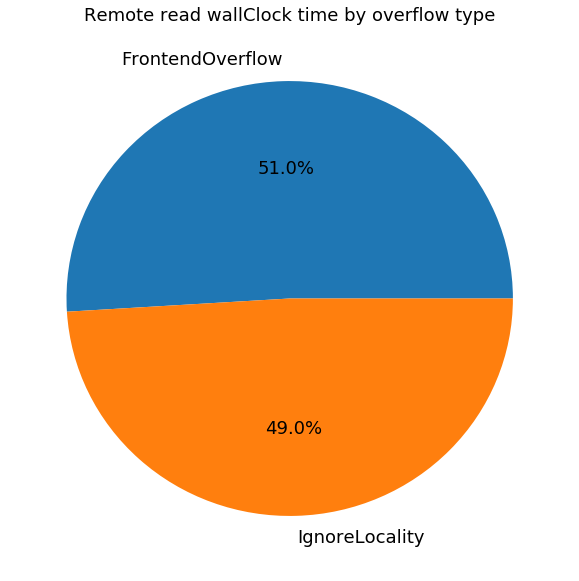

In [256]:
plot_series = data[data['InputData']=='Offsite'].groupby('OverflowType').apply(lambda x: x['WallClock'].sum())
wc_remote_by_overflow_type = pd.DataFrame({'walltime': plot_series.values}, index=plot_series.index)

ax = wc_remote_by_overflow_type.plot.pie(y='walltime', autopct='%1.1f%%', figsize=(10, 10), fontsize=18, legend=False)

ax.set_title('Remote read wallClock time by overflow type', fontdict={"fontsize":18})
ax.set_ylabel("", fontdict={"fontsize":18})

plt.savefig('%s/%s/remote_time_by_overflow_type.png' % (prefix, name))
plt.show()

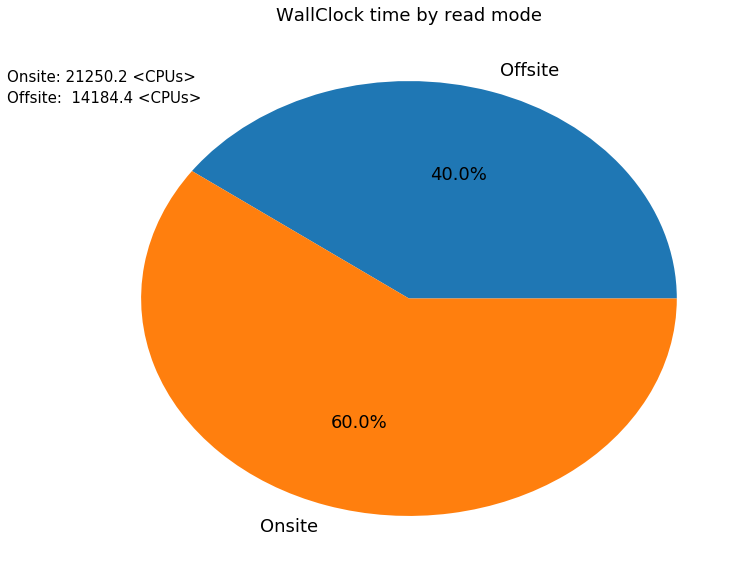

In [257]:
plot_series = data.groupby('InputData').apply(lambda x: x['WallClock'].sum())

cpu_equivalent = pd.DataFrame({'Onsite': plot_series.Onsite/total_hrs, 'Offsite': plot_series.Offsite/total_hrs},
                           index=["CPU time/total time"])


wc_remote_vs_local = pd.DataFrame({'walltime': plot_series.values}, index=plot_series.index)


fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)
ax.text(-1.5, 1,   "Onsite: %1.1f <CPUs>" % cpu_equivalent.Onsite, fontsize=15)
ax.text(-1.5, 0.9, "Offsite:  %1.1f <CPUs>" % cpu_equivalent.Offsite, fontsize=15)

wc_remote_vs_local.plot.pie(y='walltime', ax=ax, autopct='%1.1f%%', figsize=(12, 10), fontsize=18, legend=False)

ax.set_title('WallClock time by read mode', fontdict={"fontsize":18})
ax.set_ylabel("", fontdict={"fontsize":18})

#print "CPU equivalent Offsite:", plot_series.Offsite/total_hrs
#print "CPU equivalent Onsite:", plot_series.Onsite/total_hrs

plt.savefig('%s/%s/time_by_read_mode.png' % (prefix, name))
plt.show()




CMSSite
T1_DE_KIT             2.582662e+05
T1_ES_PIC             1.991097e+04
T1_FR_CCIN2P3         4.001392e+04
T1_IT_CNAF            9.447243e+03
T1_RU_JINR            1.771995e+04
T1_UK_RAL             5.713358e+04
T1_US_FNAL            3.250185e+04
T2_AT_Vienna          1.465321e+05
T2_BE_IIHE            5.646088e+05
T2_BE_UCL             2.284167e+05
T2_BR_SPRACE          4.834041e+05
T2_CH_CERN            1.147865e+07
T2_CH_CSCS            2.283137e+05
T2_CH_CSCS_HPC        3.347718e+05
T2_CN_Beijing         1.971645e+05
T2_DE_DESY            1.879482e+06
T2_DE_RWTH            8.211737e+05
T2_EE_Estonia         2.228213e+06
T2_ES_CIEMAT          7.152174e+04
T2_ES_IFCA            4.217280e+05
T2_FI_HIP             5.405527e+04
T2_FR_CCIN2P3         2.876166e+05
T2_FR_GRIF_IRFU       9.335242e+04
T2_FR_GRIF_LLR        8.372835e+04
T2_FR_IPHC            4.443502e+04
T2_GR_Ioannina        1.747779e+04
T2_HU_Budapest        3.527962e+05
T2_IN_TIFR            5.954726e+04
T2_IT_Bari  

<Figure size 720x864 with 0 Axes>

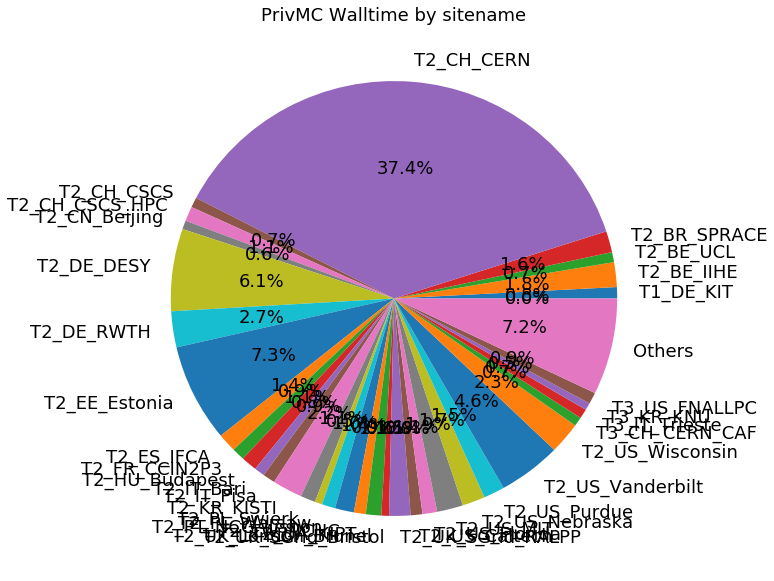

In [258]:
plot_series = data_mc.groupby('CMSSite').apply(lambda x: x['WallClock'].sum())

print plot_series

wc_by_sitename = pd.DataFrame({'walltime': plot_series.values}, index=plot_series.index)

sum_wc = data_mc.dropna(subset=['CMSSite']).WallClock.sum()
none_wc = data_mc.WallClock.sum()
wall_other = wc_by_sitename[(wc_by_sitename['walltime']/sum_wc) <= 0.005].walltime.sum()
wall_show = wc_by_sitename[(wc_by_sitename['walltime']/sum_wc) > 0.005].walltime

import numpy as np
#print sum_wc

if wall_other > 0:
    wc_by_sitename = pd.DataFrame({'walltime': np.append(wall_show.values,[wall_other, none_wc-sum_wc])},
                           index=np.append(wall_show.index, ["Others", "Unknown"]))

plt.figure(figsize=(10, 12))
ax = wc_by_sitename.plot.pie(y='walltime', autopct='%1.1f%%', figsize=(10, 10), fontsize=18, legend=False)

ax.set_title('PrivMC Walltime by sitename', fontdict={"fontsize":18})
ax.set_ylabel("", fontdict={"fontsize":18})


plt.savefig('%s/%s/time_by_sitee.png' % (prefix, name))
plt.show()

<Figure size 720x864 with 0 Axes>

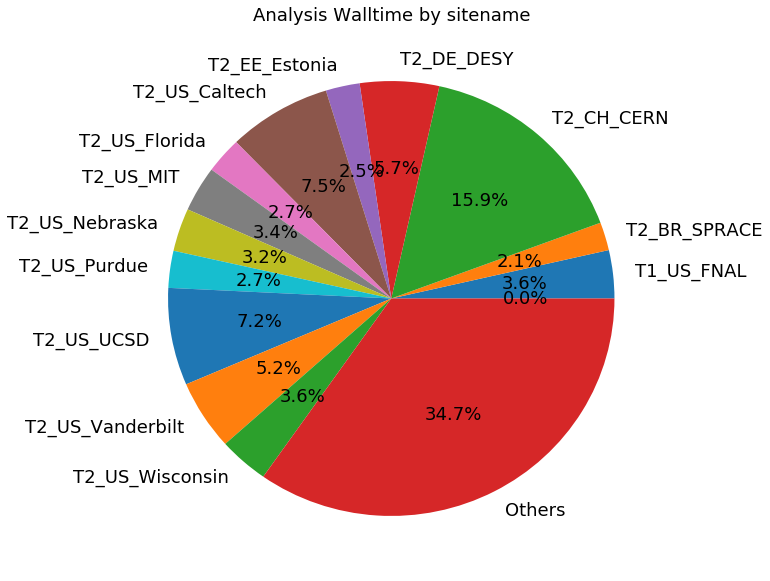

In [259]:
plot_series = data.groupby('CMSSite').apply(lambda x: x['WallClock'].sum())

wc_by_sitename = pd.DataFrame({'walltime': plot_series.values}, index=plot_series.index)

sum_wc = data.dropna(subset=['CMSSite']).WallClock.sum()
none_wc = data.WallClock.sum()
wall_other = wc_by_sitename[(wc_by_sitename['walltime']/sum_wc) <= 0.02].walltime.sum()
wall_show = wc_by_sitename[(wc_by_sitename['walltime']/sum_wc) > 0.02].walltime

import numpy as np
#print sum_wc

if wall_other > 0:
    wc_by_sitename = pd.DataFrame({'walltime': np.append(wall_show.values,[wall_other, none_wc-sum_wc])},
                           index=np.append(wall_show.index, ["Others", "Unknown"]))

plt.figure(figsize=(10, 12))
ax = wc_by_sitename.plot.pie(y='walltime', autopct='%1.1f%%', figsize=(10, 10), fontsize=18, legend=False)

ax.set_title('Analysis Walltime by sitename', fontdict={"fontsize":18})
ax.set_ylabel("", fontdict={"fontsize":18})


plt.savefig('%s/%s/time_by_sitee.png' % (prefix, name))
plt.show()

'\nplot_series = data_mc.groupby(\'CMSSite\').apply(lambda x: x[\'WallClock\'].sum())\n\nprint plot_series\n\nwc_by_sitename = pd.DataFrame({\'walltime\': plot_series.values}, index=plot_series.index)\n\nsum_wc = data_mc.dropna(subset=[\'CMSSite\']).WallClock.sum()\nnone_wc = data_mc.WallClock.sum()\nwall_other = wc_by_sitename[(wc_by_sitename[\'walltime\']/sum_wc) <= 0.02].walltime.sum()\nwall_show = wc_by_sitename[(wc_by_sitename[\'walltime\']/sum_wc) > 0.02].walltime\n\nimport numpy as np\n#print sum_wc\n\nif wall_other > 0:\n    wc_by_sitename = pd.DataFrame({\'walltime\': np.append(wall_show.values,[wall_other, none_wc-sum_wc])},\n                           index=np.append(wall_show.index, ["Others", "Unknown"]))\n\nplt.figure(figsize=(10, 12))\nwc_by_sitename.plot.pie(y=\'walltime\', title=\'WallClock time by sitename\', autopct=\'%1.1f%%\', figsize=(10, 10), fontsize=18, legend=False)\nplt.savefig(\'plots/%s/time_mc_by_sitee.png\' % name)\nplt.show()\n'

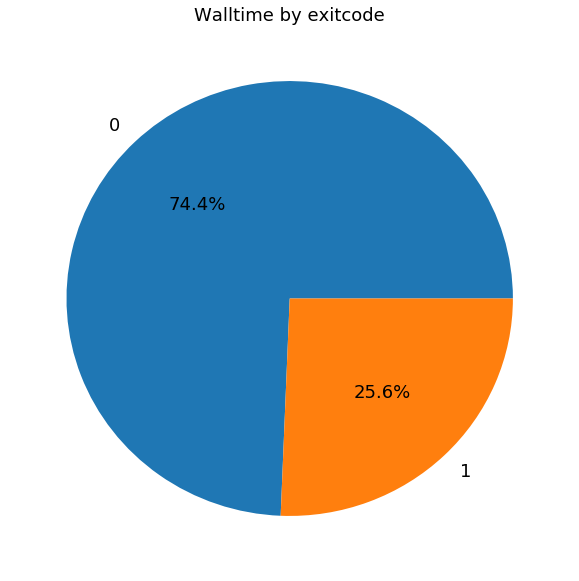

In [261]:
plot_series = data.groupby('ExitCode').apply(lambda x: x['WallClock'].sum())

wc_by_exitcode = pd.DataFrame({'walltime': plot_series.values}, index=plot_series.index)

ax = wc_by_exitcode.plot.pie(y='walltime', title='WallClock time by exitcode', autopct='%1.1f%%', figsize=(10, 10), fontsize=18, legend=False)

ax.set_title('Walltime by exitcode', fontdict={"fontsize":18})
ax.set_ylabel("", fontdict={"fontsize":18})

#print "CPU equivalent 0:", plot_series[0]/total_hrs
#print "CPU equivalent 1:", plot_series[1]/total_hrs

plt.savefig('%s/%s/time_by_exitcode.png' % (prefix, name))
plt.show()

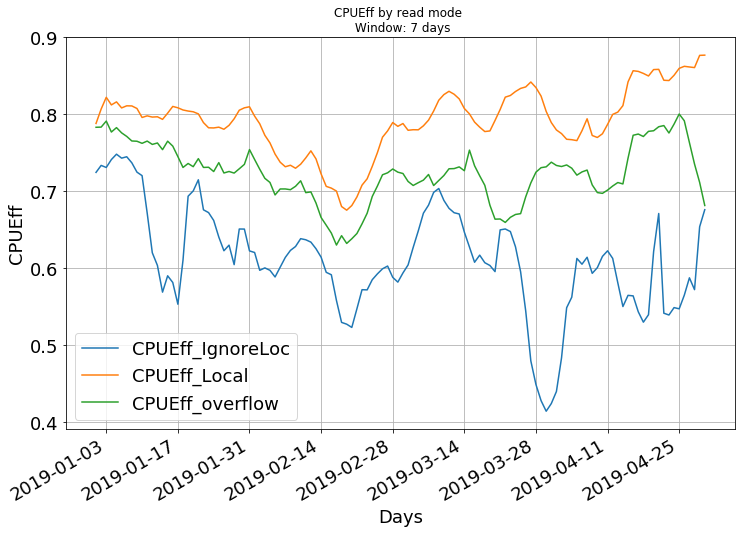

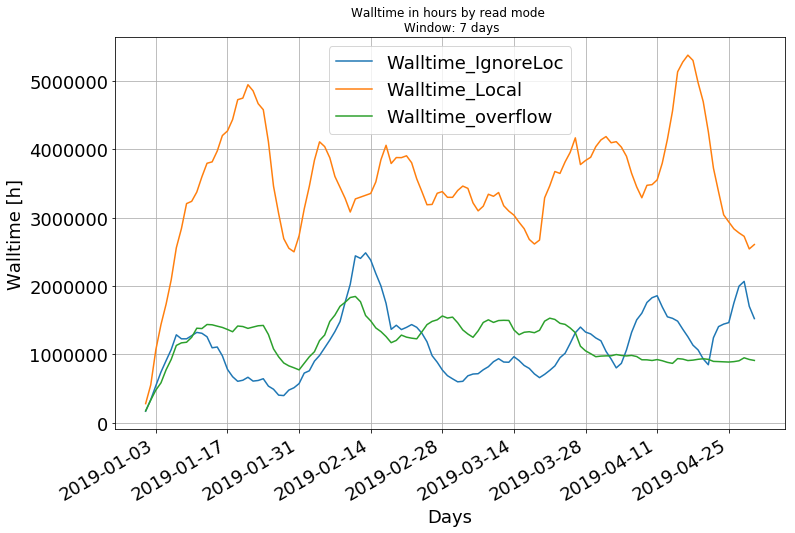

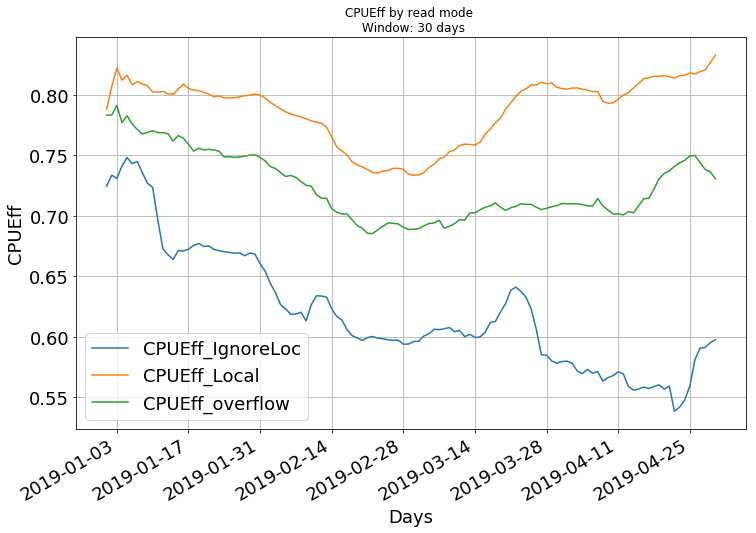

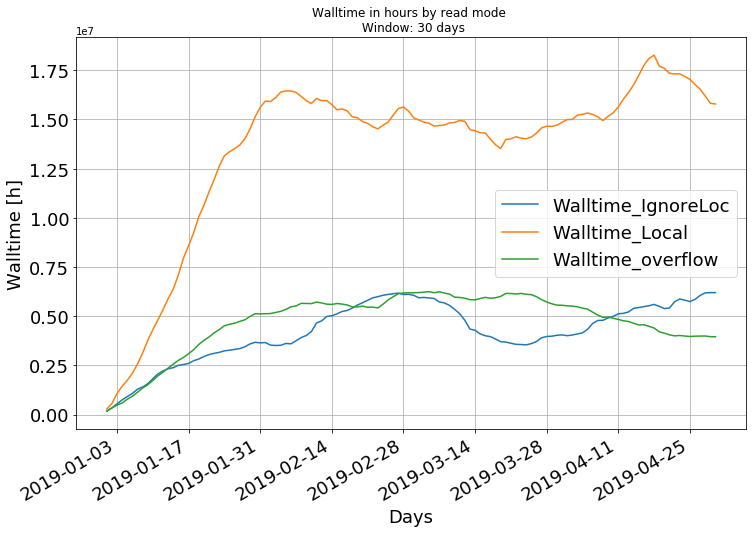

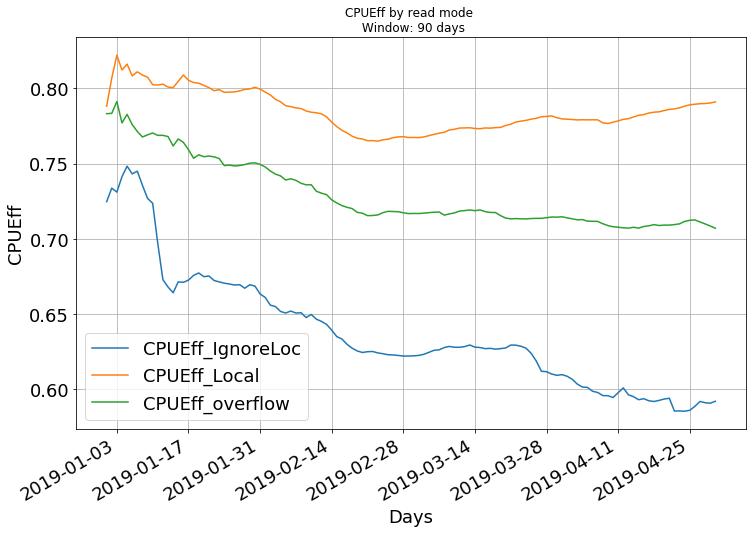

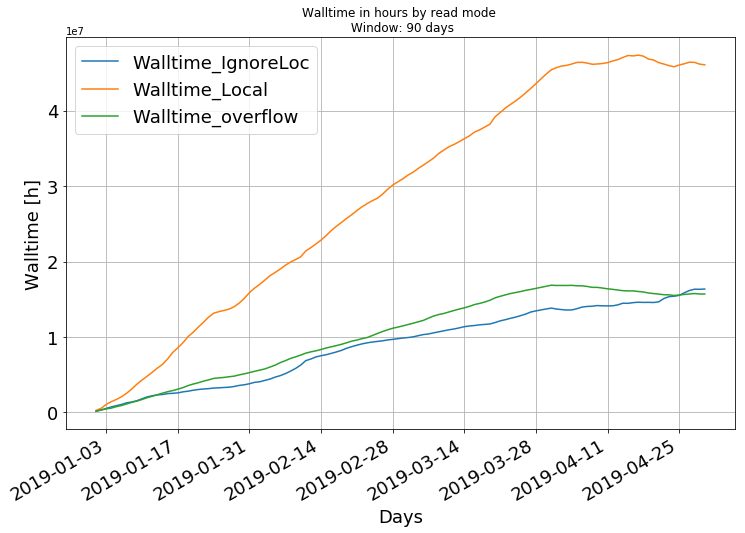

In [262]:

for window in windows:
    if not ignore_overflow:
        serie = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']!='IgnoreLocality')].groupby('day').WallClock.sum()
        wall_off = make_window_sum(serie, window)


        serie = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']!='IgnoreLocality')].groupby('day').CPUTime.sum()
        cpu_off = make_window_sum(serie, window)


    serie = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']=='IgnoreLocality')].groupby('day').WallClock.sum()
    wall_ign = make_window_sum(serie, window)

    serie = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']=='IgnoreLocality')].groupby('day').CPUTime.sum()
    cpu_ign = make_window_sum(serie, window)


    serie = data[(data['ExitCode']>=0.0) & (data['InputData']=="Onsite")].groupby('day').WallClock.sum()
    wall = make_window_sum(serie, window)

    serie = data[(data['ExitCode']>=0.0) & (data['InputData']=="Onsite")].groupby('day').CPUTime.sum()
    cpu = make_window_sum(serie, window)

    if not ignore_overflow:
        cpu_eff_off = (cpu_off/wall_off).reindex(cpu.index, method='bfill', fill_value=0)

    cpu_eff_ign = (cpu_ign/wall_ign).reindex(cpu.index, method='bfill', fill_value=0)

    cpu_eff_loc = (cpu/wall).reindex(cpu.index, method='bfill', fill_value=0)

    if not ignore_overflow:
        cpu_eff = pd.DataFrame({'CPUEff_overflow': cpu_eff_off.values, 
                                'CPUEff_IgnoreLoc': cpu_eff_ign.values, 
                                'CPUEff_Local': cpu_eff_loc.values}, 
                               index=cpu.index)
    else:
            cpu_eff = pd.DataFrame({
                                'CPUEff_IgnoreLoc': cpu_eff_ign.values, 
                                'CPUEff_Local': cpu_eff_loc.values}, 
                               index=cpu.index)

    ax = cpu_eff.plot(title='CPUEff by read mode \n Window: %s days' % window, figsize=(12, 8), fontsize=18, x_compat=True)

    ax.legend(fontsize=18 )
    ax.grid(True)


    ax.tick_params(labelsize=18)

    ax.set_xlabel("Days", fontdict={"fontsize":18})
    ax.set_ylabel("CPUEff", fontdict={"fontsize":18})

    
    plt.savefig('%s/%s/CPUEff_%sd_window_by_read_mode.png' % (prefix,name,window))
    plt.show()

    if not ignore_overflow:
        wall_off = wall_off.reindex(wall.index, method='bfill', fill_value=0)
    wall_ign = wall_ign.reindex(wall.index, method='bfill', fill_value=0)
    wall_loc = wall.reindex(wall.index, method='bfill', fill_value=0)

    if not ignore_overflow:
        wall_plot = pd.DataFrame({'Walltime_overflow': wall_off.values, 
                                'Walltime_IgnoreLoc': wall_ign.values, 
                                'Walltime_Local': wall_loc.values}, 
                               index=wall.index)
    else:
        wall_plot = pd.DataFrame({
                                'Walltime_IgnoreLoc': wall_ign.values, 
                                'Walltime_Local': wall_loc.values}, 
                               index=wall.index)

    ax = wall_plot.plot(title='Walltime in hours by read mode \n Window: %s days' % window, figsize=(12, 8), fontsize=18, x_compat=True)

    ax.legend(fontsize=18 )
    ax.grid(True)


    ax.tick_params(labelsize=18)

    ax.set_xlabel("Days", fontdict={"fontsize":18})
    ax.set_ylabel("Walltime [h]", fontdict={"fontsize":18})
    
    plt.savefig('%s/%s/Walltime-hrs_%sd_window_by_read_mode.png' % (prefix,name,window))
    plt.show()

In [263]:
data['country_order'] = data.CMSSite.apply(lambda x: re.search('T*_(.*)', x, re.IGNORECASE).group(1) if re.search('T*_(.*)', x, re.IGNORECASE) else 'Other')

<Figure size 1152x1800 with 0 Axes>

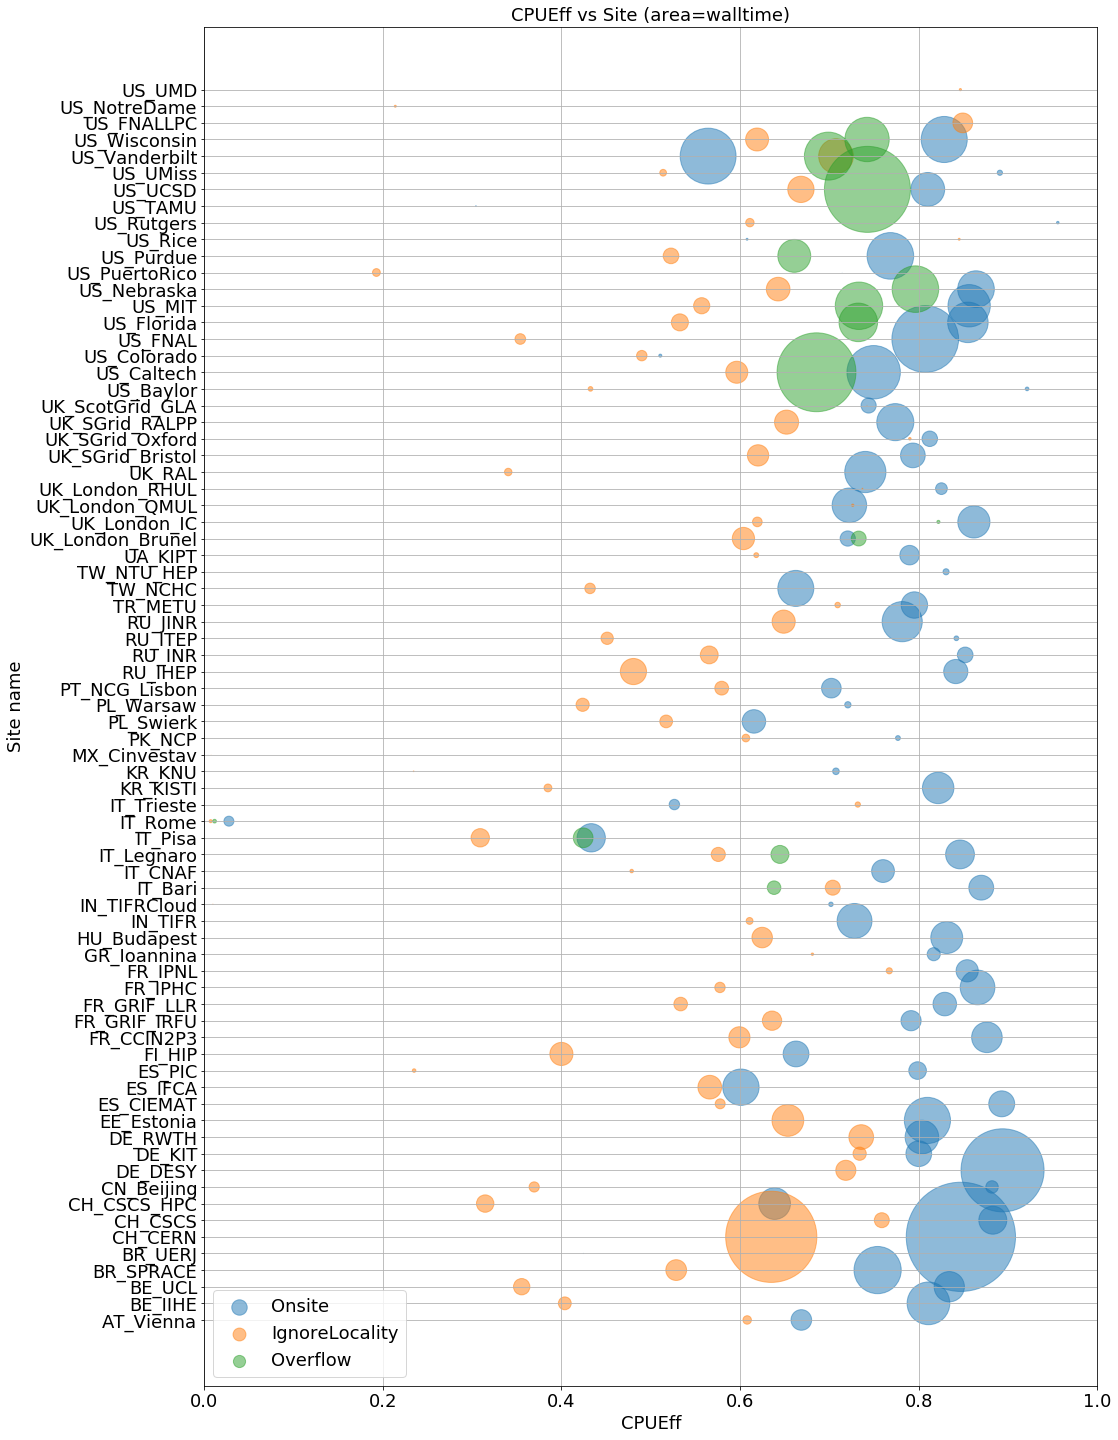

In [264]:
wall_ign = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']=='IgnoreLocality')].groupby('country_order').WallClock.sum()
cpu_ign = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']=='IgnoreLocality')].groupby('country_order').CPUTime.sum()

if not ignore_overflow:
    wall_off = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']!='IgnoreLocality')].groupby('country_order').WallClock.sum()
    cpu_off = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']!='IgnoreLocality')].groupby('country_order').CPUTime.sum()
    cpu_eff_off = (cpu_off/wall_off)

    #print "CPUEff Offsite Overflow:\t", cpu_off/wall_off

wall = data[(data['ExitCode']>=0.0) & (data['InputData']=="Onsite")].groupby('country_order').WallClock.sum()
cpu = data[(data['ExitCode']>=0.0) & (data['InputData']=="Onsite")].groupby('country_order').CPUTime.sum()

cpu_eff_ign = (cpu_ign/wall_ign)
cpu_eff = (cpu/wall)

#print cpu_eff

scale = 800

plt.figure(figsize=(16, 25))
fig, ax = plt.subplots(figsize=(16, 25))
ax.scatter(cpu_eff.values, cpu_eff.index, s=wall.values/scale, alpha=0.5, label="Onsite")
ax.scatter(cpu_eff_ign.values, cpu_eff_ign.index, s=wall_ign.values/scale, alpha=0.5, label="IgnoreLocality")
if not ignore_overflow:
    ax.scatter(cpu_eff_off.values, cpu_eff_off.index, s=wall_off.values/scale, alpha=0.5, label="Overflow")

ax.legend(markerscale=0.2, fontsize=18 )
ax.grid(True)

ax.set_xlim([0,1])

ax.tick_params(labelsize=18)

ax.set_xlabel("CPUEff", fontdict={"fontsize":18})
ax.set_ylabel("Site name", fontdict={"fontsize":18})
ax.set_title("CPUEff vs Site (area=walltime)", fontdict={"fontsize":18})

#cpu_eff.plot('scatter')
plt.savefig('%s/%s/scatter_cpueff_by_site.png' % (prefix, name))
plt.show()

<Figure size 1152x1440 with 0 Axes>

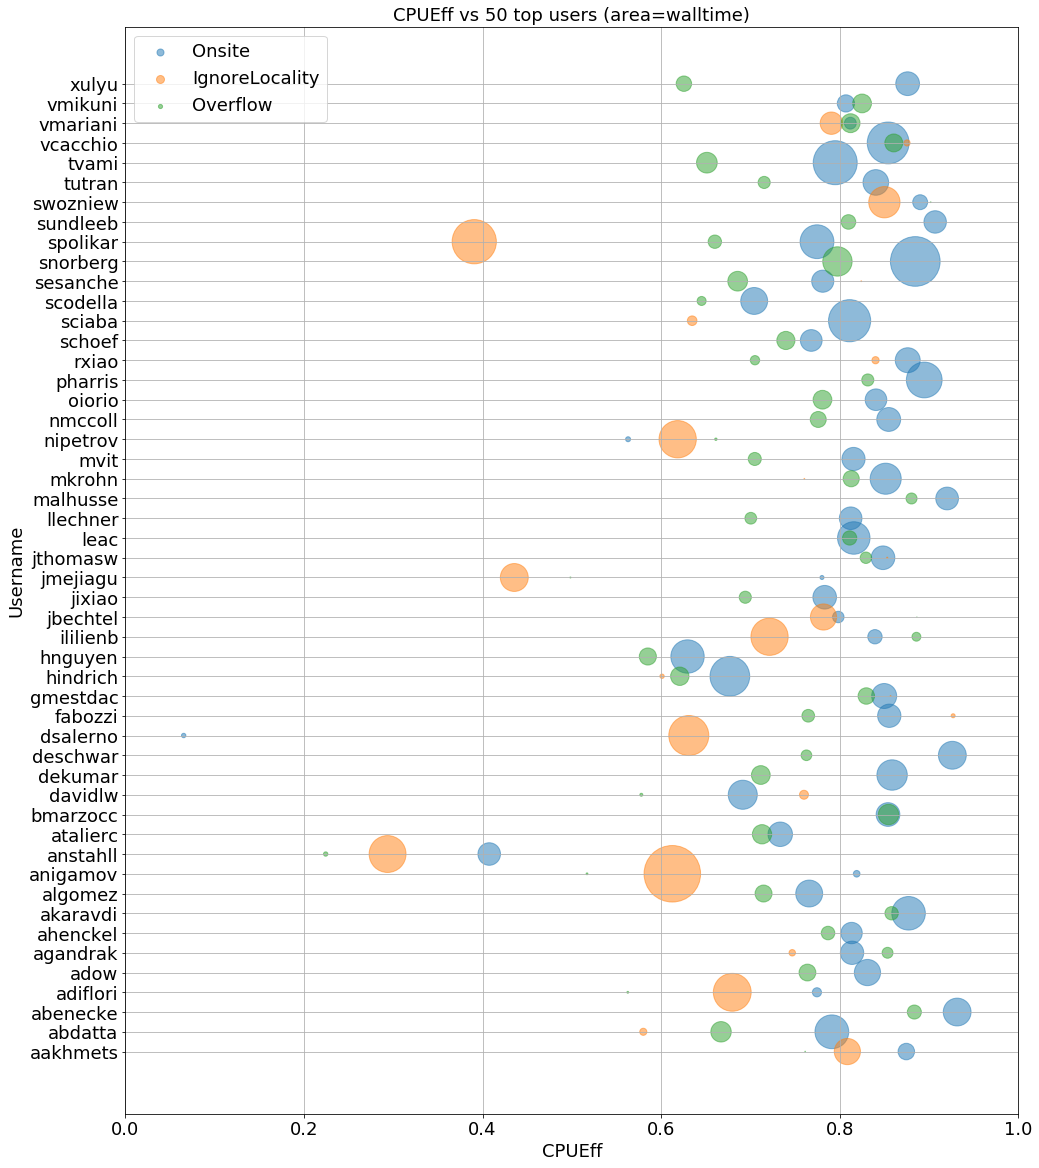

In [265]:
users = data[(data['ExitCode']>=0.0)].groupby('CRAB_UserHN').WallClock.sum().nlargest(50)

data_ign_tmp = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']=='IgnoreLocality') & (data['CRAB_UserHN'].isin(users.index)) ].groupby('CRAB_UserHN')

wall_ign = data_ign_tmp.WallClock.sum()
cpu_ign = data_ign_tmp.CPUTime.sum()

if not ignore_overflow:
    data_off_tmp = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']!='IgnoreLocality') & (data['CRAB_UserHN'].isin(users.index)) ].groupby('CRAB_UserHN')
    wall_off = data_off_tmp.WallClock.sum()
    cpu_off = data_off_tmp.CPUTime.sum()
    cpu_eff_off = (cpu_off/wall_off)

    #print "CPUEff Offsite Overflow:\t", cpu_off/wall_off
data_tmp = data[(data['ExitCode']>=0.0) & (data['InputData']=="Onsite") & (data['CRAB_UserHN'].isin(users.index)) ].groupby('CRAB_UserHN')
wall = data_tmp.WallClock.sum()
cpu = data_tmp.CPUTime.sum()

cpu_eff_ign = (cpu_ign/wall_ign)
cpu_eff = (cpu/wall)


#print cpu_eff

plt.figure(figsize=(16, 20))
fig, ax = plt.subplots(figsize=(16, 20))

scale = 800

ax.scatter(cpu_eff.values, cpu_eff.index, s=wall.values/scale, alpha=0.5, label="Onsite")
ax.scatter(cpu_eff_ign.values, cpu_eff_ign.index, s=wall_ign.values/scale, alpha=0.5, label="IgnoreLocality")
if not ignore_overflow:
    ax.scatter(cpu_eff_off.values, cpu_eff_off.index, s=wall_off.values/scale, alpha=0.5, label="Overflow")

ax.legend(markerscale=0.2, fontsize=18 )
ax.grid(True)

ax.set_xlim([0,1])

ax.tick_params(labelsize=18)
ax.set_xlabel("CPUEff", fontdict={"fontsize":18})
ax.set_ylabel("Username", fontdict={"fontsize":18})

ax.set_title("CPUEff vs 50 top users (area=walltime)", fontdict={"fontsize":18})
#cpu_eff.plot('scatter')
plt.savefig('%s/%s/scatter_cpueff_by_user.png' % (prefix, name))
plt.show()

<Figure size 1152x1440 with 0 Axes>

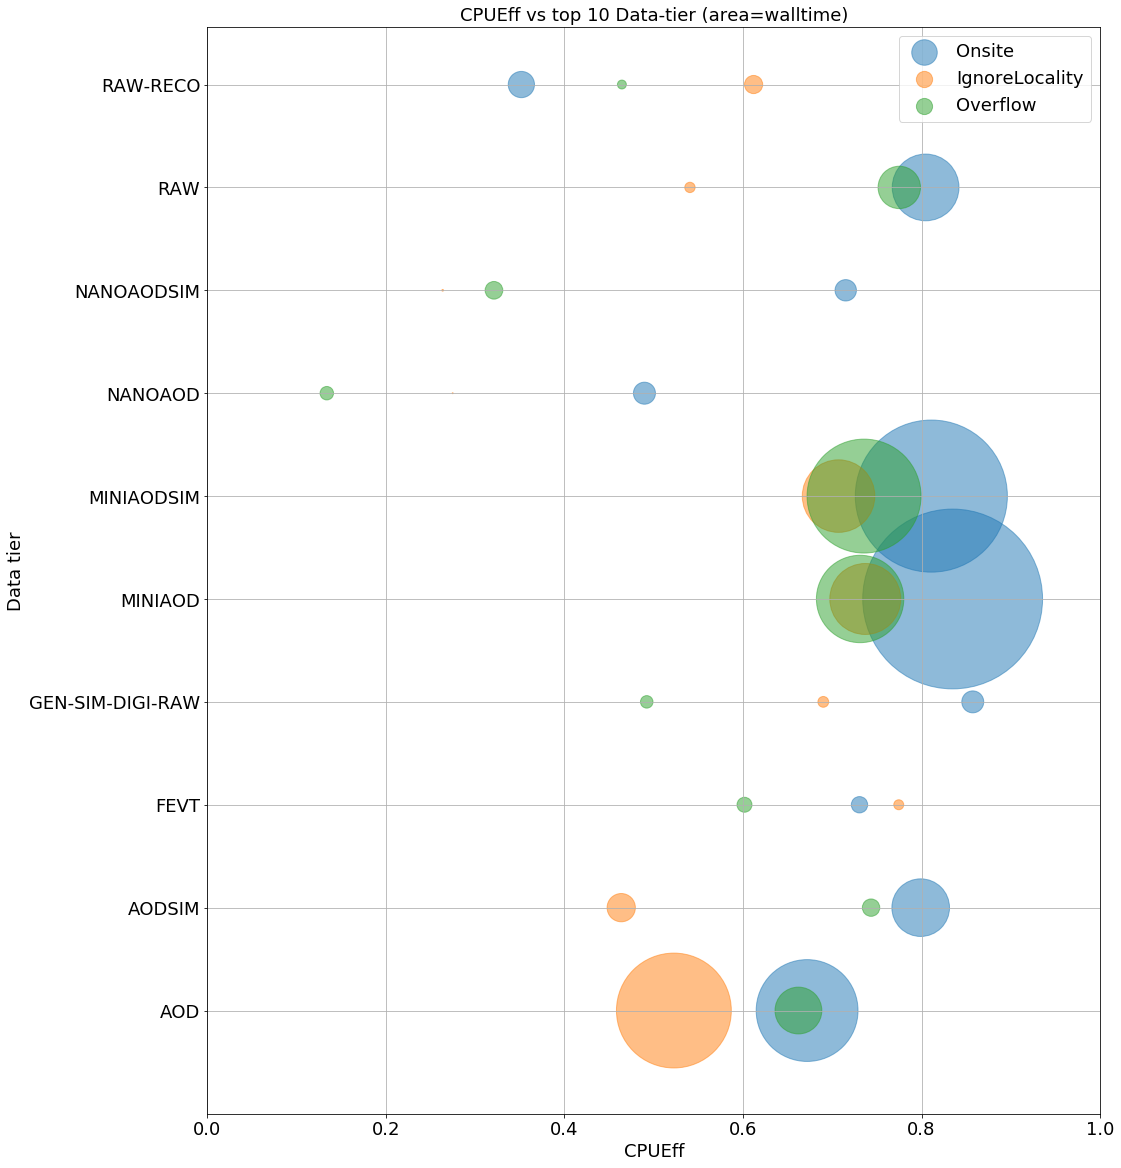

In [266]:
top = data[(data['ExitCode']>=0.0)].groupby('data_label').WallClock.sum().nlargest(10)

data_ign_tmp = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']=='IgnoreLocality') & (data['data_label'].isin(top.index)) ].groupby('data_label')

wall_ign = data_ign_tmp.WallClock.sum()
cpu_ign = data_ign_tmp.CPUTime.sum()

if not ignore_overflow:
    data_off_tmp = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']!='IgnoreLocality') & (data['data_label'].isin(top.index)) ].groupby('data_label')
    wall_off = data_off_tmp.WallClock.sum()
    cpu_off = data_off_tmp.CPUTime.sum()
    cpu_eff_off = (cpu_off/wall_off)

    #print "CPUEff Offsite Overflow:\t", cpu_off/wall_off
data_tmp = data[(data['ExitCode']>=0.0) & (data['InputData']=="Onsite") & (data['data_label'].isin(top.index))].groupby('data_label')
wall = data_tmp.WallClock.sum()
cpu = data_tmp.CPUTime.sum()

cpu_eff_ign = (cpu_ign/wall_ign)
cpu_eff = (cpu/wall)


#print cpu_eff

plt.figure(figsize=(16, 20))
fig, ax = plt.subplots(figsize=(16, 20))

scale = 800

ax.scatter(cpu_eff.values, cpu_eff.index, s=wall.values/scale, alpha=0.5, label="Onsite")
ax.scatter(cpu_eff_ign.values, cpu_eff_ign.index, s=wall_ign.values/scale, alpha=0.5, label="IgnoreLocality")
if not ignore_overflow:
    ax.scatter(cpu_eff_off.values, cpu_eff_off.index, s=wall_off.values/scale, alpha=0.5, label="Overflow")

ax.legend(markerscale=0.2, fontsize=18 )
ax.grid(True)

ax.set_xlim([0,1])

ax.tick_params(labelsize=18)
ax.set_xlabel("CPUEff", fontdict={"fontsize":18})
ax.set_ylabel("Data tier", fontdict={"fontsize":18})

plt.title("CPUEff vs top 10 Data-tier (area=walltime)", fontdict={"fontsize":18})
#cpu_eff.plot('scatter')
plt.savefig('%s/%s/scatter_cpueff_by_data_tier.png' % (prefix, name))
plt.show()

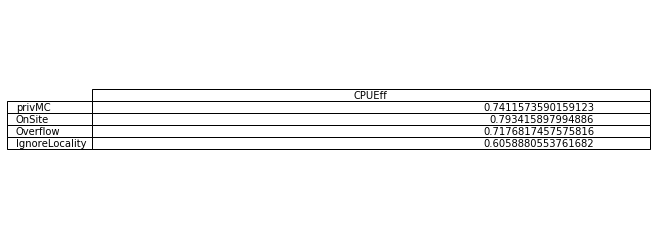

<Figure size 720x720 with 0 Axes>

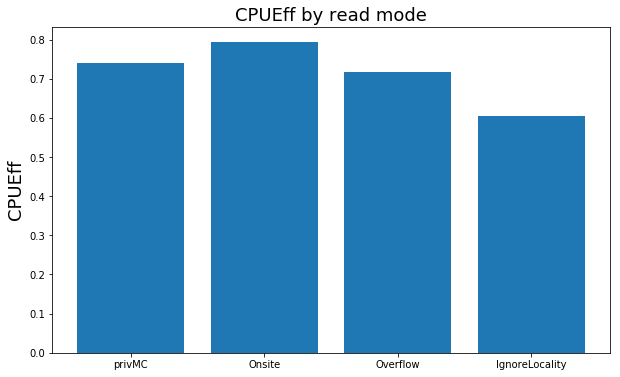

In [267]:
wall_ign = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']=='IgnoreLocality')].WallClock.sum()
cpu_ign = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']=='IgnoreLocality')].CPUTime.sum()

#print "CPUEff Offsite IgnoreLocality:\t", cpu_ign/wall_ign

if not ignore_overflow:
    wall_off = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']!='IgnoreLocality')].WallClock.sum()
    cpu_off = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']!='IgnoreLocality')].CPUTime.sum()

    #print "CPUEff Offsite Overflow:\t", cpu_off/wall_off

wall = data[(data['ExitCode']>=0.0) & (data['InputData']=="Onsite")].WallClock.sum()
cpu = data[(data['ExitCode']>=0.0) & (data['InputData']=="Onsite")].CPUTime.sum()

wall_mc = data.WallClock.sum()
cpu_mc = data.CPUTime.sum()

#print "CPUEff Onsite:\t\t\t", cpu/wall

if not ignore_overflow:
    cpu_eff_table = pd.DataFrame({'CPUEff': [cpu_mc/wall_mc, cpu/wall, cpu_off/wall_off, cpu_ign/wall_ign]},
                           index=["privMC", "OnSite", "Overflow", "IgnoreLocality"])
else:
    cpu_eff_table = pd.DataFrame({'CPUEff': [cpu_mc/wall_mc, cpu/wall, cpu_ign/wall_ign]},
                           index=["privMC", "OnSite", "IgnoreLocality"])

plt.figure(figsize=(10, 4))
ax2 = plt.subplot(111)
plt.axis('off')
tbl = table(ax2, cpu_eff_table, loc='center')
tbl.auto_set_font_size(True)
#tbl.set_fontsize(10)

plt.savefig('%s/%s/cpueff_by_read_mode_table.png' % (prefix, name))

plt.figure(figsize=(10, 10))
if not ignore_overflow:
    plt.figure(figsize=(10, 6))
    plt.bar(["privMC", "Onsite", "Overflow", "IgnoreLocality"],[cpu_mc/wall_mc, cpu/wall,cpu_off/wall_off, cpu_ign/wall_ign ])
    plt.ylabel('CPUEff',fontdict={"fontsize":18})
    plt.title('CPUEff by read mode',fontdict={"fontsize":18})
    plt.savefig('%s/%s/cpueff_by_read_mode.png' % (prefix, name))
    plt.show()
else:
    plt.figure(figsize=(10, 6))
    plt.bar(["privMC", "Onsite", "IgnoreLocality"],[cpu_mc/wall_mc, cpu/wall, cpu_ign/wall_ign ])
    plt.ylabel('CPUEff',fontdict={"fontsize":18})
    plt.title('CPUEff by read mode',fontdict={"fontsize":18})
    plt.savefig('%s/%s/cpueff_by_read_mode.png' % (prefix, name))
    plt.show()


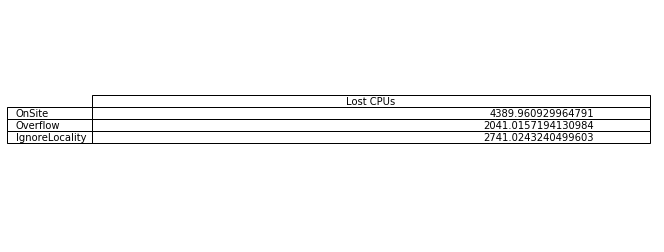

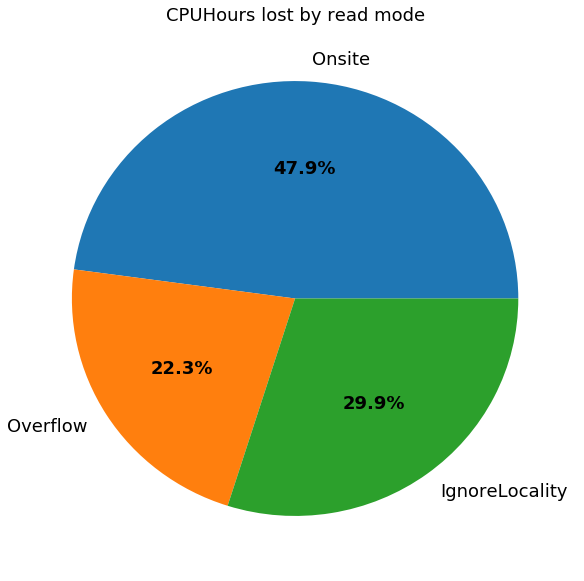

In [268]:
# CPU loss
# histo cpu eff
wall_ign = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']=='IgnoreLocality')].WallClock.sum()
cpu_ign = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']=='IgnoreLocality')].CPUTime.sum()

#print "CPULoss Offsite IgnoreLocality:\t", (wall_ign - cpu_ign)

if not ignore_overflow:
    wall_off = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']!='IgnoreLocality')].WallClock.sum()
    cpu_off = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']!='IgnoreLocality')].CPUTime.sum()

    #print "CPULoss Offsite Overflow:\t", (wall_off - cpu_off)

wall = data[(data['ExitCode']>=0.0) & (data['InputData']=="Onsite")].WallClock.sum()
cpu = data[(data['ExitCode']>=0.0) & (data['InputData']=="Onsite")].CPUTime.sum()

#print "CPULoss Onsite:\t\t\t", (wall - cpu)/total_hrs

if not ignore_overflow:
    lost_cpus_table = pd.DataFrame({'Lost CPUs': [(wall - cpu)/total_hrs, (wall_off - cpu_off)/total_hrs ,(wall_ign - cpu_ign)/total_hrs]},
                           index=["OnSite", "Overflow","IgnoreLocality"])
else:
    lost_cpus_table = pd.DataFrame({'Lost CPUs': [(wall - cpu)/total_hrs ,(wall_ign - cpu_ign)/total_hrs]},
                           index=["OnSite", "IgnoreLocality"])    

plt.figure(figsize=(10, 4))
ax2 = plt.subplot(111)
plt.axis('off')
tbl = table(ax2, lost_cpus_table, loc='center')
tbl.auto_set_font_size(True)
#tbl.set_fontsize(10)

plt.savefig('%s/%s/lost_cpus_by_read_mode_table.png' % (prefix, name))



plt.figure(figsize=(10, 10))
if not ignore_overflow:
    wedges, texts, autotexts = plt.pie([(wall-cpu), (wall_off-cpu_off), (wall_ign-cpu_ign)], labels=["Onsite", "Overflow", "IgnoreLocality"], autopct='%1.1f%%', textprops={"fontsize":18})
else:
    wedges, texts, autotexts = plt.pie([(wall-cpu), (wall_ign-cpu_ign)], labels=["Onsite", "IgnoreLocality"], autopct='%1.1f%%', textprops={"fontsize":18})
    
plt.setp(texts, size=18)
plt.setp(autotexts, size=18, weight="bold")
plt.title('CPUHours lost by read mode',fontdict={"fontsize":18})

plt.savefig('%s/%s/lost_cpus_by_read_mode.png' % (prefix, name))
plt.show()

Total:			35434.65998707562
CPUCache gain Overflow:	547.518953840067


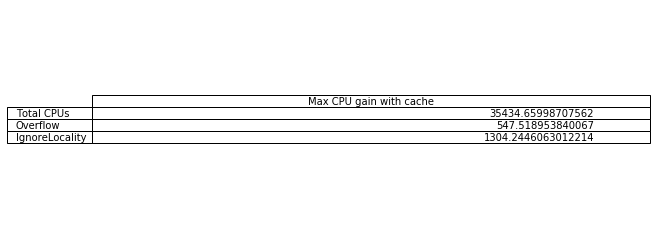

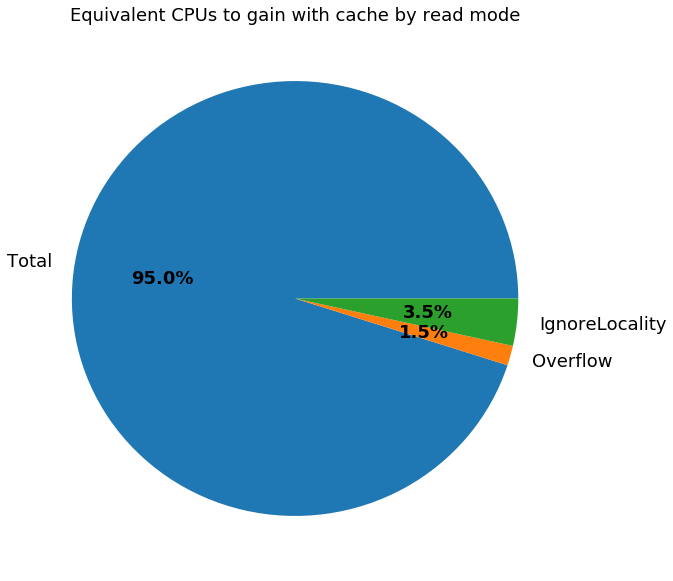

In [269]:

wall_ign = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']=='IgnoreLocality')].WallClock.sum()
cpu_ign = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']=='IgnoreLocality')].CPUTime.sum()

if not ignore_overflow:
    wall_off = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']!='IgnoreLocality')].WallClock.sum()
    cpu_off = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']!='IgnoreLocality')].CPUTime.sum()


wall = data[(data['ExitCode']>=0.0) & (data['InputData']=="Onsite")].WallClock.sum()
cpu = data[(data['ExitCode']>=0.0) & (data['InputData']=="Onsite")].CPUTime.sum()

cache_gain_ign = (wall_ign - cpu_ign)*(1-(1/((wall_ign - cpu_ign)*wall/(wall_ign*(wall - cpu)))))/total_hrs

if not ignore_overflow:
    cache_gain_off = (wall_off - cpu_off)*(1-(1/((wall_off - cpu_off)*wall/(wall_off*(wall - cpu)))))/total_hrs

if ignore_overflow:
    total = (wall+wall_ign)/total_hrs
else:
    total = (wall+wall_off+wall_ign)/total_hrs
#wall_off_tot = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite")].WallClock.sum()
#total2 = (wall+wall_off_tot)/total_hrs

print "Total:\t\t\t", total
#print "Remote Unknown:", total2
#print "CPU Cache gain IgnoreLocality:\t", cache_gain_ign

if not ignore_overflow:
    print "CPUCache gain Overflow:\t", cache_gain_off

if not ignore_overflow:
    cpu_gain_table = pd.DataFrame({'Max CPU gain with cache': [total, cache_gain_off , cache_gain_ign]},
                           index=["Total CPUs", "Overflow","IgnoreLocality"])
else:
    cpu_gain_table = pd.DataFrame({'Max CPU gain with cache': [total, cache_gain_ign]},
                           index=["Total CPUs", "IgnoreLocality"])    

plt.figure(figsize=(10, 4))
ax2 = plt.subplot(111)
plt.axis('off')
tbl = table(ax2, cpu_gain_table, loc='center')
tbl.auto_set_font_size(True)

plt.savefig('%s/%s/cpu_gain_by_read_mode_table.png' % (prefix, name))

plt.figure(figsize=(10, 10))
if ignore_overflow:
    wedges, texts, autotexts = plt.pie([total, cache_gain_ign], labels=["Total", "IgnoreLocality"], autopct='%1.1f%%', textprops={"fontsize":18})
else:
    wedges, texts, autotexts = plt.pie([total, cache_gain_off, cache_gain_ign], labels=["Total", "Overflow", "IgnoreLocality"], autopct='%1.1f%%', textprops={"fontsize":18})

plt.setp(texts, size=18)
plt.setp(autotexts, size=18, weight="bold")
plt.title('Equivalent CPUs to gain with cache by read mode',fontdict={"fontsize":18})

plt.savefig('%s/%s/cpu_gain_by_read_mode.png' % (prefix, name))
plt.show()

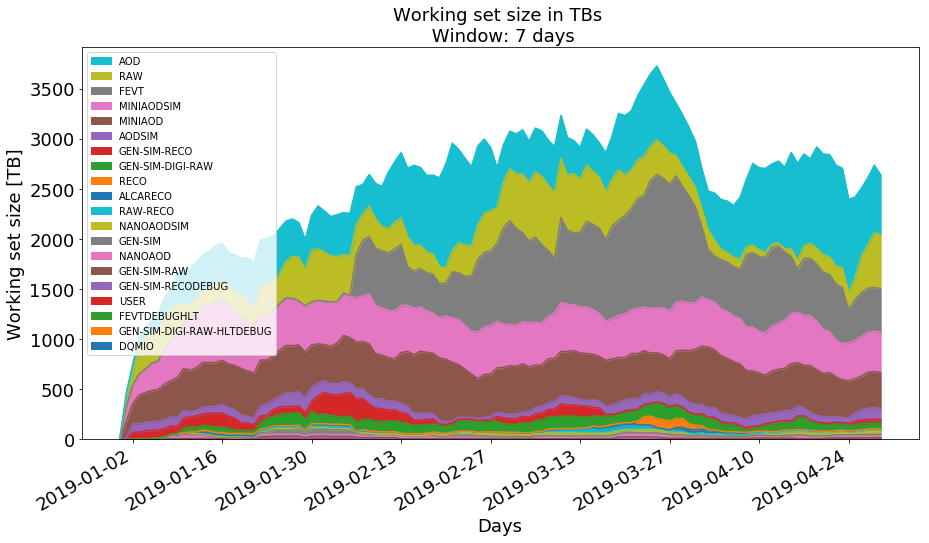

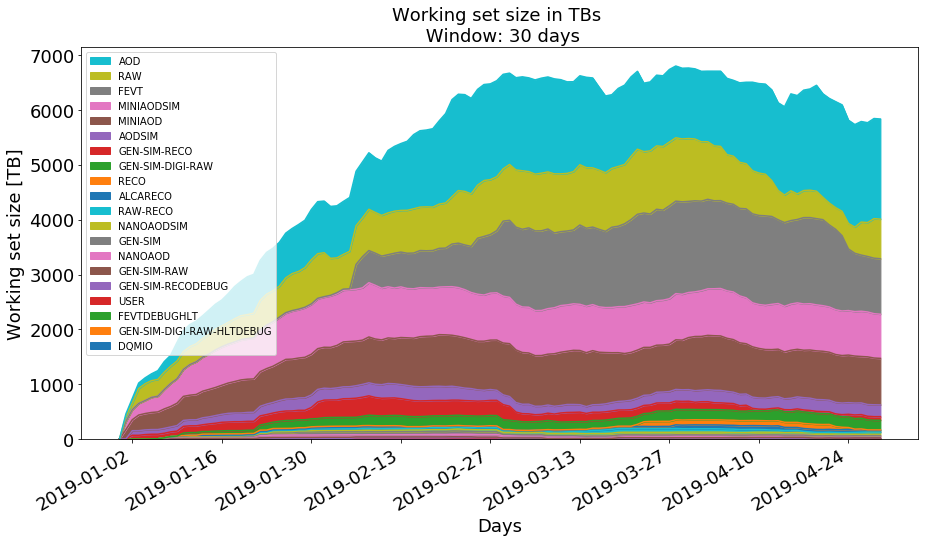

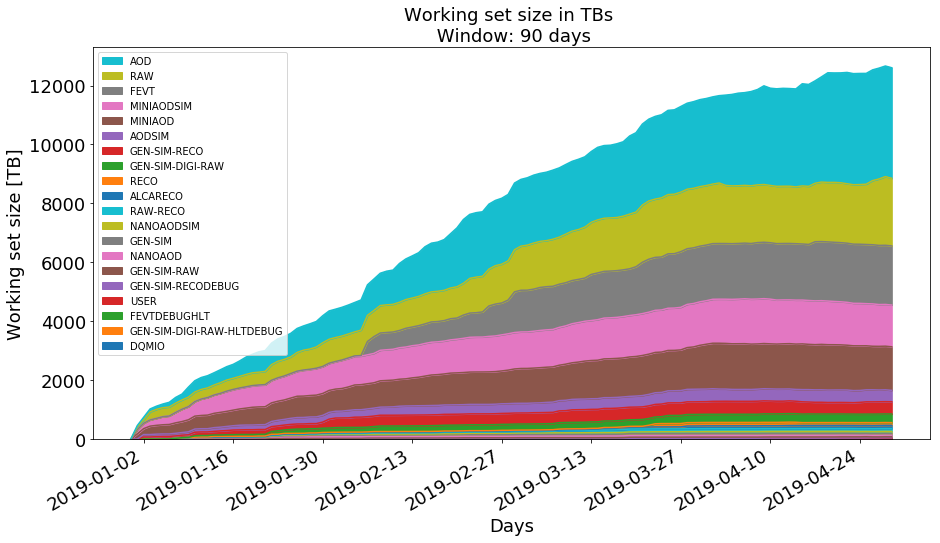

In [270]:
#print data.groupby('day').CRAB_DataBlock.unique()
def make_window_ws(df, window_in_day):
    item_sum = []
    date = start_date
    
    item_sum = []
    index = []
    while date < end_date:
        start_interval = date - datetime.timedelta(days=window)

        item_sum.append(df[(df['day'] > start_interval) & (df['day'] <= date)].CRAB_DataBlock.unique())

        index.append(date)
        
        date += datetime.timedelta(days=1)


    return pd.Series(data=item_sum, index=index)


block_sizes = data.groupby('CRAB_DataBlock').block_size.max()

tier_list = data.drop_duplicates(subset=['block_size']).groupby('data_label').apply(lambda x: x['block_size'].sum()).sort_values()

#print tier_list.index

df_list = []
for tier in tier_list.index:
    df_list.append(data[data['data_label']==tier].groupby('day').CRAB_DataBlock.apply(pd.Series)\
          .reset_index())

for window in windows:
    sum_list = []
    for my_f in df_list:
        sum_size = []
        index = []
        for i, test in make_window_ws(my_f, window).items():
            #print len(test)
            sum_tmp = 0
            #print i
            for block in test:
                sum_tmp += block_sizes[block]
            sum_size.append(sum_tmp)
            index.append(i)
        sum_list.append(sum_size)
        
        #print len(sum_list)
    #print len(np.random.randn(120, 4))
    #print zip(*sum_list)

    ax = (pd.DataFrame(data=zip(*sum_list), index=index, columns=tier_list.index)/1E12)\
                            .plot(kind='area', figsize=(15, 8), fontsize=18, x_compat=True, stacked=True)
                             #.plot(title='Working set size in TBs \n Window: %s days' % window, figsize=(10, 5), fontsize=18, x_compat=True, stacked=True)
                             
    h, l = ax.get_legend_handles_labels()
    ax.legend(reversed(h), reversed(l))
    ax.set_title('Working set size in TBs \n Window: %s days' % window, fontdict={"fontsize":18})
    ax.set_ylabel('Working set size [TB]', fontdict={"fontsize":18})
    ax.set_xlabel('Days', fontdict={"fontsize":18})
            
    plt.savefig('%s/%s/ws_size_%sd_window_allTiers.png' % (prefix, name, window))
    plt.show()

In [224]:
# TODO: same plots for offsite vs onsite

In [200]:
# TODO: MINI,NANOAOD only